<a href="https://colab.research.google.com/github/Yuuuugo/Food101/blob/main/Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!nvidia-smi -L #Factory reset the runtime until it is set to a Tesla T4

GPU 0: Tesla T4 (UUID: GPU-0a19e429-b6f0-397e-67df-50fd14cc54cd)


In [18]:
#Need a version of tensorflow < 2.5 because there is a bug with MixedPrecision
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 462 kB 70.2 MB/s 
     |████████████████████████████████| 3.8 MB 53.4 MB/s 
     |████████████████████████████████| 132 kB 74.9 MB/s 
     |████████████████████████████████| 2.9 MB 54.3 MB/s 
     |████████████████████████████████| 14.8 MB 55.3 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=61778f9d4fabca6ca1c3f1d6fa1cbac8d388edc8f7e2a0edaa11cf20d26a5700
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting

In [19]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [7]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt

In [4]:
# Import helper functions file
!wget https://raw.githubusercontent.com/Yuuuugo/Food101/main/helper_functions.py

--2022-04-18 14:31:14--  https://raw.githubusercontent.com/Yuuuugo/Food101/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10247 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-18 14:31:15 (76.3 MB/s) - ‘helper_functions.py’ saved [10247/10247]



In [5]:
from helper_functions import *

In [9]:
(train_data, test_data ),info = tfds.load(name ="food101",
                                              split = ["train","validation"],
                                              shuffle_files = True,
                                              as_supervised = True,
                                              with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIC1AP4/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteIC1AP4/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].class_names

In [10]:
#Explore the Data 
sample = train_data.take(1)
sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for image, label in sample :
  print(f"""
        Image shape : {image.shape}
        Image datatype : {image.dtype}
        Class format : {label}
        """)


        Image shape : (382, 512, 3)
        Image datatype : <dtype: 'uint8'>
        Class format : 52
        


(-0.5, 511.5, 381.5, -0.5)

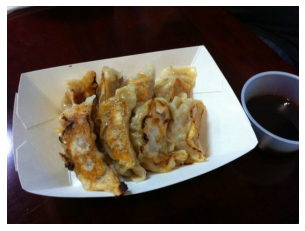

In [13]:
#Visualize an image
plt.imshow(image)
plt.title(f"""Class name : { class_names[label.numpy()]}""")
plt.axis(False)

#Try to do it for several images and not only one

In [15]:
# Preprocessing the data
def preprocessing_image(image, label, img_shape = 224):
  """
  Change the image type form uint8 to float32, reshape them to (224,224,3) and scale them between 0 and 1 if necessary
  """
  image = tf.resize(image, (img_shape, img_shape,3))
  image = tf.cast(image, tf.float32)
  # image = image/255 # Not required if using EfficientNetBX models 
  return image,label

# We have to keep the label in the function even if we don't do modify it since we will use this in the map function that take both image and label as 
# an input

In [ ]:
# Batch and prepare the datasets
train_data = train_data.map(map_func = preprocessing_image,
                            num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefect(buffer_size = tf.data.AUTOTUNE)

test_data = test_data.map(map_func = preprocessing_image,num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefect(buffer_size = tf.data.AUTOTUNE)

In [16]:
#Set the CALLBACKS to use 

CHECKPOINT_PATH = "model_checkpoint/cp.cpkt"

CALLBACKS = [
      tf.keras.callbacks.ModelCheckpoint(filepath = CHECKPOINT_PATH,
                                         monitor = "vall_acc",
                                         save_best_only = True,
                                         save_weights_only = True
                                         )
]

In [27]:
# Set up MixedPrecision Training
from tensorflow.keras import mixed_precision # with tf 2.8

mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

In [30]:
# Build the feature extractor model

from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "input_layers")
#x = preprocessing.Rescaling(1/255.)(inputs) # Not Necessary with EfficientNetBX
x = base_model(inputs, training = False) # Don't want to retrain the EfficientNet for now 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "output_layer")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [32]:
# Compile the model
model.compile(
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"],
    optimizer = tf.keras.optimizers.Adam()
)

In [34]:
# Check if the model is using mix policies layers per layers
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layers True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [ ]:
# Train the model 